In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds   
import os 

In [4]:
# TDL : 
# strat update de la cov
# checker le calcul dynamique des poids 
# calculer les metrics de mon portefeuille 

# créer un module avec les fonctions utiles

# add transaction costs and volatility scaling cf. 4.4 dans l'article 

In [5]:
# article du papier, (préférer celui de CHOUEIFATY - Toward Maximum Diversification)
# https://www.tandfonline.com/doi/epdf/10.1080/23322039.2018.1427533?needAccess=true

In [1]:
# Data loading 

# from 2006 to 2020 daily 
# test from 2011 to end of april 2020

tickers = ['VTI', 'AGG', 'DBC', '^VIX']
start = "2006-01-01"
end = "2020-12-31"
period = "1d"
window = 50

In [6]:
df_original = yf.download(tickers, start=start, end=end, period=period)['Adj Close']
df_original.index = df_original.index.strftime("%Y-%m-%d")

[*********************100%***********************]  4 of 4 completed


In [19]:
# un court check sur DBC

for col in df_original.columns:
    print(df_original[col].first_valid_index())

2006-01-03
2006-02-06
2006-01-03
2006-01-03


In [23]:
# data cleaning & creating rets and ma
df = df_original.copy()

cols_rets = [f"{asset}_r" for asset in tickers]
df[cols_rets] = df[tickers].pct_change()

cols_mavg = [f"{col}_mavg_50d" for col in cols_rets]
df[cols_mavg] = df[cols_rets].rolling(window=window).mean()

cols_vol = [f"{col}_vol_50d" for col in cols_rets]
df[cols_vol] = df[cols_rets].rolling(window=window).std()

df_with_na = df.copy() 
df.dropna(inplace=True)

df

Ticker,AGG,DBC,VTI,^VIX,VTI_r,AGG_r,DBC_r,^VIX_r,VTI_r_mavg_50d,AGG_r_mavg_50d,DBC_r_mavg_50d,^VIX_r_mavg_50d,VTI_r_vol_50d,AGG_r_vol_50d,DBC_r_vol_50d,^VIX_r_vol_50d
Date,,,,,,,,,,,,,,,,
2006-04-19,55.700787,22.356941,46.467957,11.320000,0.002987,0.000915,0.009747,-0.007018,0.000813,-0.000212,0.001441,-0.001952,0.005784,0.002232,0.012977,0.042051
2006-04-20,55.615814,22.097979,46.531864,11.640000,0.001375,-0.001526,-0.011583,0.028269,0.001035,-0.000229,0.001788,-0.002230,0.005581,0.002239,0.012366,0.041798
2006-04-21,55.610210,22.564108,46.510571,11.590000,-0.000458,-0.000101,0.021094,-0.004296,0.000882,-0.000221,0.002295,-0.001198,0.005513,0.002238,0.012630,0.041076
2006-04-24,55.819656,22.115244,46.375698,11.750000,-0.002900,0.003766,-0.019893,0.013805,0.000862,-0.000157,0.001709,-0.001374,0.005525,0.002306,0.012968,0.040991
2006-04-25,55.632835,22.184299,46.226639,11.750000,-0.003214,-0.003347,0.003123,0.000000,0.000757,-0.000182,0.002136,-0.000993,0.005552,0.002334,0.012647,0.040911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,106.353706,13.794738,182.168045,23.309999,0.001710,-0.000679,0.012517,-0.037969,0.001588,0.000074,0.001958,-0.000181,0.010220,0.001907,0.009066,0.065785
2020-12-24,106.452942,13.832635,182.472794,21.530001,0.001673,0.000933,0.002747,-0.076362,0.001754,0.000080,0.001877,-0.001961,0.010150,0.001910,0.009040,0.066630
2020-12-28,106.470993,13.747366,183.627319,21.700001,0.006327,0.000170,-0.006164,0.007896,0.001874,0.000101,0.001693,-0.002235,0.010169,0.001905,0.009109,0.066559


In [25]:
# covariance annualisée sur toute la période 

cov = df[cols_mavg].cov()
cov * 252 

Ticker,VTI_r_mavg_50d,AGG_r_mavg_50d,DBC_r_mavg_50d,^VIX_r_mavg_50d
Ticker,,,,
VTI_r_mavg_50d,0.000567,0.000004,0.000445,-0.002333
AGG_r_mavg_50d,0.000004,0.000029,-0.000016,-0.000054
DBC_r_mavg_50d,0.000445,-0.000016,0.000998,-0.002065
^VIX_r_mavg_50d,-0.002333,-0.000054,-0.002065,0.017095


In [72]:
# fonctions qui calculent les poids de la strat 

def diversification_ratio(w, cov):
    sigma = np.sqrt(np.diag(cov))
    wT_sigma = w.T @ sigma 
    wT_cov_w = w.T @ cov @ w 
    return wT_sigma / (np.sqrt(wT_cov_w))

def get_weights_md(cov, bounds=None):
    """
    We get the weights by minimizing the negative diversification ratio
    """
    
    n_assets = cov.shape[0]
    w0 = np.ones(n_assets) / n_assets 

    # Defining the loss and the weight constraint

    def loss(w, cov):
        return - diversification_ratio(w, cov)

    def constraint(w):
        return w.sum() - 1 
    
    cons = {'type': 'eq', 'fun': constraint}
            
    res = minimize(
        fun = loss,
        x0 = w0,
        constraints=cons,
        args=cov,
        bounds=bounds,
        method='SLSQP'
    )

    return res.x  

In [75]:
get_weights_md(cov)

array([0.31060094, 0.5348875 , 0.08393792, 0.07057364])

In [91]:
# Old version - Penser à implémenter une version plus rapide avec rolling et cov  

def optimize_portfolio_md(returns, rolling_window=50, bounds=None):
    """
    Prend en entrée le df des returns et retourne un df avec poids de la stratégie
    avec les covariances estimées sur la fenêtre donnée en input 
    """
    # check valid input  

    if not isinstance(returns, pd.DataFrame):
        raise ValueError("please input returns as a dataframe") 

    _, n_assets = returns.shape

    # computing the rolling cov

    cov_rolling = returns.rolling(window=rolling_window).cov().dropna()
    
    # extracting the unique date index from the multindex 

    dates = cov_rolling.index.get_level_values('Date').unique()
    n_dates = len(dates)

    # initializing the weight matrix 

    weights_matrix_df = pd.DataFrame(np.zeros(shape=(n_dates, n_assets)))
    weights_matrix_df.index = dates
    weights_matrix_df.columns = cov_rolling.columns 

    for date in dates:
        cov = cov_rolling.loc[date]
        weights_matrix_df.loc[date] = get_weights_md(cov, bounds=bounds)

    return weights_matrix_df  


    

In [84]:

bounds = tuple((0, 1) for _ in range(4))
weights_matrix = optimize_portfolio_md(returns_mavg, bounds=bounds, rolling_window=window)

69.93768390000332


In [92]:
# saving the weights

path_dir = os.getcwd()
version = 2
name_output = f"weights_md_{version}.csv"
path = path_dir + "\\output\\" + name_output
weights_matrix.to_csv(path)

In [93]:
weights_matrix_check = np.isclose(weights_matrix.iloc[:, 0:4].sum(axis=1), 1.0, atol=1e-6)

all_rows_valid = weights_matrix_check.all()
print("All rows sum to 1" if all_rows_valid else "Some rows do not sum to 1.")

weights_matrix

All rows sum to 1


Ticker,VTI_r_mavg_50d,AGG_r_mavg_50d,DBC_r_mavg_50d,^VIX_r_mavg_50d
Date,,,,
2006-06-28,0.732717,0.176053,0.000000e+00,0.091230
2006-06-29,0.667562,0.249804,2.253562e-10,0.082634
2006-06-30,0.574638,0.356233,0.000000e+00,0.069130
2006-07-03,0.532457,0.404686,5.528234e-13,0.062858
2006-07-05,0.526842,0.411175,6.883564e-08,0.061983
...,...,...,...,...
2020-12-23,0.385620,0.490722,4.493034e-02,0.078727
2020-12-24,0.395397,0.467766,5.515507e-02,0.081682
2020-12-28,0.417090,0.437139,5.996316e-02,0.085808


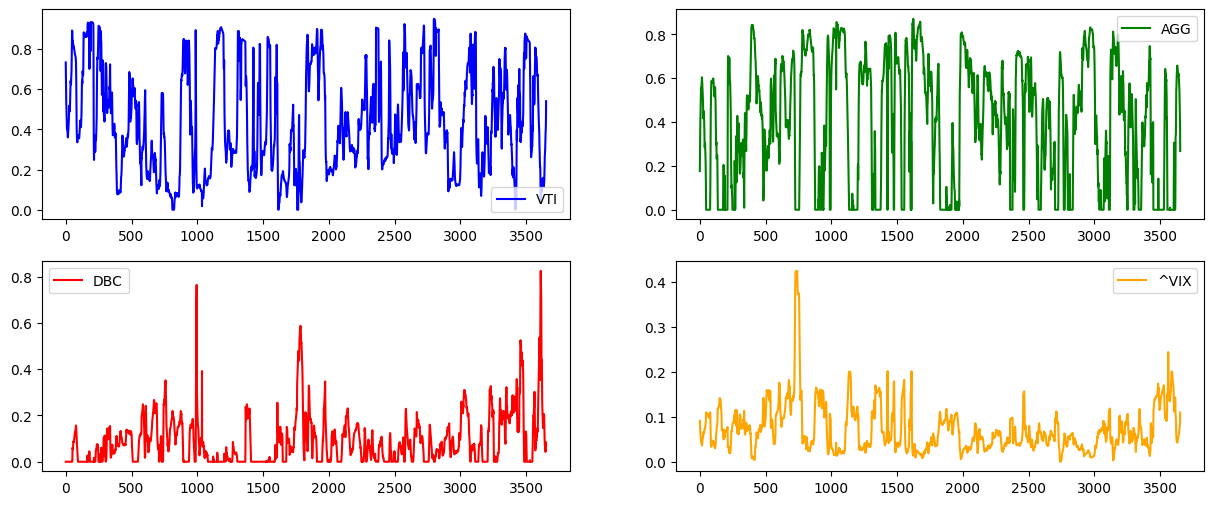

In [94]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
colors = ['blue', 'green', 'red', 'orange']
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].plot(weights_matrix.iloc[:,i].values, label=tickers[i], color=colors[i])
    axs[i].legend()

In [95]:
# getting the returns

returns = df[cols_rets]

column_mapping = dict(zip(weights_matrix.columns[0:4], cols_rets))

weights_renamed = weights_matrix.iloc[:,0:4].rename(columns=column_mapping)

common_dates = returns.index.intersection(weights_matrix.index)

weighted_returns = weights_renamed.loc[common_dates] * returns.loc[common_dates]
portfolio_md_rets = weighted_returns.sum(axis=1).to_frame("portfolio_md_rets")
portfolio_md_rets["cumulative_rets"] = (1 + portfolio_md_rets.loc[:,"portfolio_md_rets"]).cumprod() - 1 
portfolio_md_rets

,portfolio_md_rets,cumulative_rets
Date,,
2006-06-28,0.001617,0.001617
2006-06-29,0.001005,0.002624
2006-06-30,-0.000045,0.002579
2006-07-03,0.004562,0.007153
2006-07-05,-0.000307,0.006844
...,...,...
2020-12-23,-0.002100,2.599267
2020-12-24,-0.004988,2.581314
2020-12-28,0.003021,2.592133


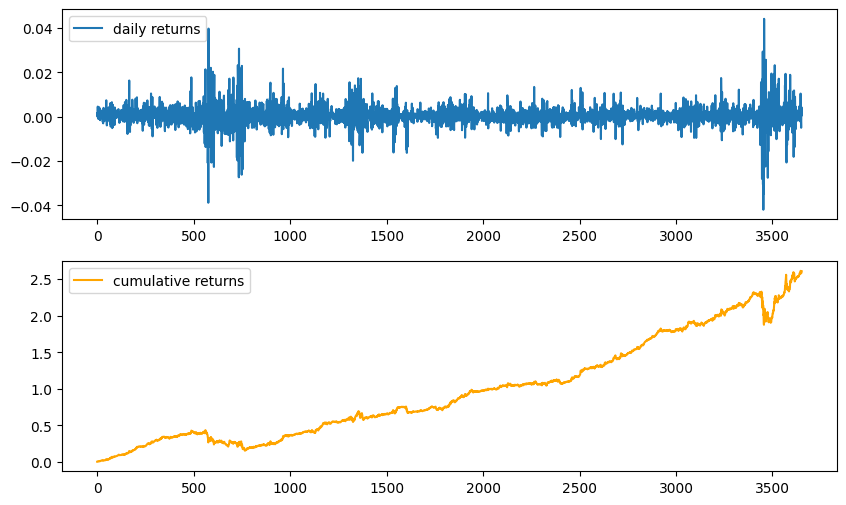

In [96]:
fig, axs = plt.subplots(2,1, figsize=(10, 6))

axs[0].plot(portfolio_md_rets["portfolio_md_rets"].values, label="daily returns")
axs[0].legend()
axs[1].plot(portfolio_md_rets["cumulative_rets"].values, label="cumulative returns", color='orange')
axs[1].legend()

In [97]:
portfolio_return = (1 + portfolio_md_rets["portfolio_md_rets"].mean()) ** 252 - 1
portfolio_volatility = portfolio_md_rets["portfolio_md_rets"].std() * np.sqrt(252)
sharpe = portfolio_return / portfolio_volatility

print(f"Annualized Return: {portfolio_return:.2%}")
print(f"Annualized Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

Annualized Return: 9.56%
Annualized Volatility: 7.41%
Sharpe Ratio: 1.29
